In [12]:
from clp.src.algorithm.chromosome import Chromosome, Improvement
from clp.src.algorithm.gene import Gene
from clp.src.graphic.draw_container import draw
from clp.src.problems.problems import Problems
import json
from IPython.display import clear_output
from matplotlib import pyplot as plt
import os 
import imageio
from PIL import Image as PILImage
from PIL import ImageChops

def crop_image(image_path, manual_crop_box=None):
    image = PILImage.open(image_path)
    image.load()
    image = image.convert("RGBA")
    if manual_crop_box:
        return image.crop(manual_crop_box)
    bg = PILImage.new("RGBA", image.size, (255, 255, 255, 0))
    diff = ImageChops.difference(image, bg)
    bbox = diff.getbbox()
    if bbox:
        return image.crop(bbox)
    return image

# Cargar resultados
results = []
with open('results.txt', 'r', encoding='utf-8', newline='\n') as r: 
    for line in r:
        json_line = json.loads(line)
        results.append(json_line)

# Cargar problemas
problems = {}
for i in [5,10,20,30,40,50]:
    ps = Problems(file_path='problems/types_%d.json' % i).load_problems()
    for p in ps:
        if i not in problems:
            problems[i] = {}
        problems[i][p.id] = p        

result = {}
# Buscar el mejor resultado
for r in results:
    if r['group_improvement'] != 'during' or r['types_count'] < 20:
        continue
    if not result or (r['best_value'][2] > result['best_value'][2]):
        result = r

problem = problems[result['types_count']][result['problem_id']]
box_types = problem.box_types
best_solution = result['best_solution']
group_improvement = result['group_improvement']
print(best_solution)
genes = [Gene(type=box_types[b[0]], box_count=b[1], rotation=b[2])
         for b in best_solution]
e = Chromosome(genes=genes, container=problem.container)
imp = Improvement.during if group_improvement == 'during' else Improvement.none
e.evaluate(improvement=imp)
if group_improvement in ['late_all', 'late_best', 'late_some']:
    e.evaluate_with_improvement_late()

fig = draw(e.result, '', problem.container)
contenedorLlenoPath = 'clp/presentation/pic/contenedor-lleno.png'
fig.savefig(contenedorLlenoPath, format='png', transparent=True, bbox_inches='tight', pad_inches=0)

# Define manual crop box (left, upper, right, lower)
left, upper = 60,290
manual_crop_box = (left, upper, left + 1030, upper + 538)

cropped_image = crop_image(contenedorLlenoPath, manual_crop_box)
cropped_image.save(contenedorLlenoPath, "PNG") 

[[14, 24, 1], [3, 18, 0], [18, 42, 0], [2, 27, 1], [1, 0, 0], [9, 0, 1], [16, 17, 1], [4, 51, 1], [13, 35, 0], [15, 48, 1], [7, 55, 1], [5, 15, 1], [0, 18, 0], [17, 73, 0], [12, 40, 0], [10, 32, 1], [6, 47, 1], [8, 53, 0], [19, 69, 1], [11, 91, 0]]


In [6]:
# Define manual crop box (left, upper, right, lower)
left, upper = 496,455
manual_crop_box = (left, upper, left + 1030, upper + 538)

output_dir = 'animation'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

filenames = []

for i in range(len(e.result)):
    fig = draw(e.result[0:i], '', problem.container)
    filename_png = os.path.join(output_dir, f'figure_{i}.png')
    fig.savefig(filename_png, transparent=False)
    plt.close(fig)
    
    cropped_image = crop_image(filename_png, manual_crop_box)
    cropped_image.save(filename_png, "PNG")  # Save as PNG
    filenames.append(filename_png)

gif_filename = 'output.gif'
with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in filenames:
    os.remove(filename)
os.rmdir(output_dir)

from IPython.display import Image
Image(filename=gif_filename)

KeyboardInterrupt: 

/var/folders/p_/mq725q8n6_vgy5jvk6kn31vw0000gn/T/ipykernel_81678/1721398530.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_tab20 = cm.get_cmap('tab20', 20)


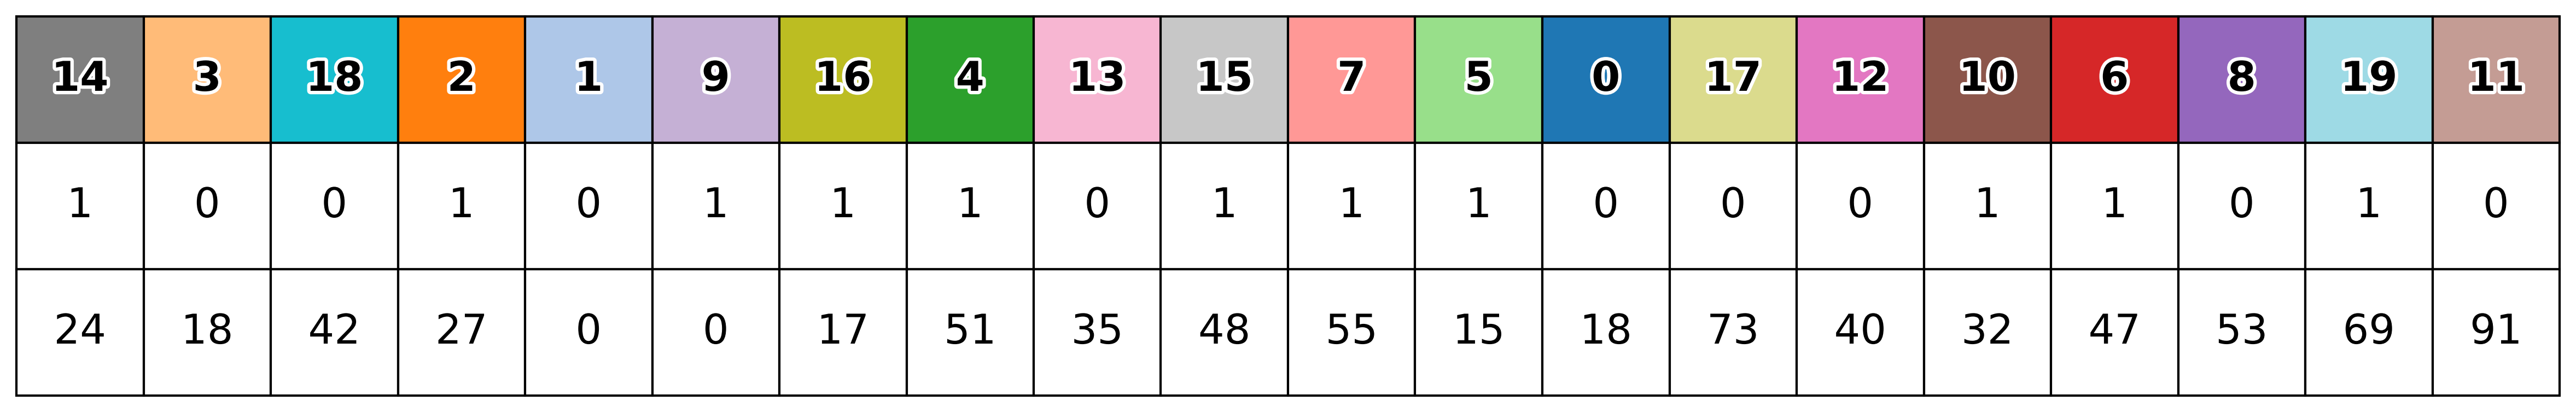

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from matplotlib.patheffects import withStroke

data = [[fila[i] for fila in best_solution] for i in range(3)]
data[1],data[2] = data[2],data[1]
df = pd.DataFrame(data, columns=[i for i in data[0]])

# Crear una figura y un eje
num_rows, num_cols = df.shape
fig, ax = plt.subplots(figsize=(num_cols, num_rows))  # Ajustar el tamaño de la figura

# Ocultar ejes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Tabla de colores aleatorios
colors_tab20 = cm.get_cmap('tab20', 20)

# Dibujar la tabla sin encabezado y con colores de fondo distintos por columna
the_table = ax.table(cellText=df.values,
                     cellLoc='center',
                     loc='center')

# Colorear cada columna y ajustar el texto
for j in range(len(df.columns)):
    
    for i in range(len(df)):
        if i == 0:
            color = colors_tab20(df.columns[j] % 20)
            the_table[(i, j)].set_facecolor(color)
            the_table[(i, j)].set_edgecolor('black')
        # Configurar el texto con color negro, borde blanco, negrita y un poco más grande
        cell = the_table[(i, j)]
        cell_text = cell.get_text()
        cell_text.set_color('black')
        cell_text.set_path_effects([withStroke(linewidth=3, foreground='white')])
        if i == 0:
            cell_text.set_fontweight('bold')  # Texto en negrita
        cell_text.set_fontsize(18)  # Tamaño de texto más grande

# Ajustar las propiedades de las celdas para hacerlas cuadradas
for key, cell in the_table.get_celld().items():
    cell.set_height(1.0 / num_rows)
    cell.set_width(1.0 / num_cols)

# Ajustar el diseño
plt.gca().autoscale_view()
plt.axis('off')

# Guardar la tabla como una imagen en la carpeta actual
output_path = 'clp/presentation/pic/tabla_colores_3x20.png'
plt.savefig(output_path, bbox_inches='tight', dpi=300)

from IPython.display import Image
Image(output_path)


In [43]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from PIL import Image

def plot_cuboid(size, color, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Crear el cuboide
    ox, oy, oz = 0, 0, 0
    dx, dy, dz = size
    vertices = np.array([
        [ox, oy, oz],
        [ox + dx, oy, oz],
        [ox + dx, oy + dy, oz],
        [ox, oy + dy, oz],
        [ox, oy, oz + dz],
        [ox + dx, oy, oz + dz],
        [ox + dx, oy + dy, oz + dz],
        [ox, oy + dy, oz + dz]
    ])
    faces = [[vertices[j] for j in [0, 1, 2, 3]],
             [vertices[j] for j in [4, 5, 6, 7]], 
             [vertices[j] for j in [0, 3, 7, 4]], 
             [vertices[j] for j in [1, 2, 6, 5]], 
             [vertices[j] for j in [0, 1, 5, 4]], 
             [vertices[j] for j in [2, 3, 7, 6]]]
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, linewidths=1, edgecolors='k', alpha=0.9))
    
    # Ajustar los límites del eje
    ax.set_xlim([0, dx])
    ax.set_ylim([0, dy])
    ax.set_zlim([0, dz])
    
    # Ocultar los ejes
    ax.set_axis_off()
    ax.set_aspect('equal')
    
    # Guardar la figura
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)

boxes_list = [b[0] for b in best_solution]
cuboides = [((box_types[b].length, box_types[b].width, box_types[b].height), colors_tab20(b)) for b in boxes_list]

# Dibujar cada cuboide en su propio lienzo
filenames = []
for i, (size, color) in enumerate(cuboides):
    filename = f'cuboid_{i}.png'
    plot_cuboid(size, color, filename)
    filenames.append(filename)

# Combinar todas las imágenes en una sola imagen larga
images = [Image.open(filename) for filename in filenames]
widths, heights = zip(*(image.size for image in images))

total_width = sum(widths) + (len(images) - 1) * 10  # Añadir espacio entre imágenes
max_height = max(heights)

combined_image = Image.new('RGB', (total_width, max_height), (255, 255, 255))

x_offset = 0
for image in images:
    combined_image.paste(image, (x_offset, 0))
    x_offset += image.width + 10  # Espacio de 10 píxeles entre imágenes

# Guardar la imagen combinada
combined_image.save('clp/presentation/pic/cubos.png')

# Mostrar la imagen combinada
combined_image.show()

# Eliminar las imágenes individuales
for filename in filenames:
    os.remove(filename)
